<div style="background:#F5F5F5; color:#000000; padding:10px">
    <p><big><b> Техническое задание. </b></big></p> 
    
    
__Задача:__
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

# Проект: A/B-тестирование.

__Описание проекта__

__Цель исследования__ - приоритизировать гипотезы для увеличения выручки интернет-магазина.

__Исследование пройдёт в два этапа:__

1. Приоритизация гипотез;
2. Анализ A/B-теста.

__Описание данных__

Данные для приоритизация гипотез взяты из таблицы /datasets/hypothesis.csv. 

- __Hypothesis__ — краткое описание гипотезы;
- __Reach__ — охват пользователей по 10-балльной шкале;
- __Impact__ — влияние на пользователей по 10-балльной шкале;
- __Confidence__ — уверенность в гипотезе по 10-балльной шкале;
- __Efforts__ — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для анализ A/B-теста взяты из таблицы /datasets/orders.csv. 

- __transactionId__ — идентификатор заказа;
- __visitorId__ — идентификатор пользователя, совершившего заказ;
- __date__ — дата, когда был совершён заказ;
- __revenue__ — выручка заказа;
- __group__ — группа A/B-теста, в которую попал заказ.

И из таблицы /datasets/visitors.csv. 
- __date__ — дата;
- __group__ — группа A/B-теста;
- __visitors__ — количество пользователей в указанную дату в указанной группе A/B-теста


In [1]:
#импортируем библиотеки 
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings

## Приоритизация гипотез.

В данном разделе приоритизируем 9 гипотез по увеличению выручки интернет-магазина. Для приоритизации гипотез будут использованы фреймворки ICE и RICE. 

In [2]:
#прочитаем датафрейм
try:
    hypothesis = pd.read_csv('/Users/angelinakotelnikova/Desktop/koTing/datasets/hypothesis.csv') 
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv') 

display(hypothesis.head(3))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3


Для начала гипотезы приоритизируем с помощью фреймворка ICE  по формуле:  

$$ ICE=\cfrac{Impact*Confidence}{Efforts} $$

In [3]:
#применим способ приоритизации гипотез ICE
hypothesis['ICE']=hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']

Теперь гипотезы приоритизируем с помощью фреймворка RICE по формуле:

$$ RICE=\cfrac{Reach*Impact*Confidence}{Efforts} $$

In [4]:
#применим способ приоритизации гипотез RICE
hypothesis['RICE']=(hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']

#отсортируем по большему числу в RICE
hypothesis = hypothesis.sort_values(by='RICE', ascending=False)

Выведем итоговую таблицу приоритизации гипотез по RICE и ICE.

In [5]:
#Выведем итоговую таблицу приоритизации гипотез по RICE и ICE
numeric_columns = ['ICE', 'RICE']

(hypothesis
 .style
 .hide_index()
 .format('{:.1f}', subset=numeric_columns)
 .highlight_max(color='yellowgreen', subset=numeric_columns)
 .background_gradient(subset=numeric_columns, cmap='BuGn')
 .set_properties(**{'text-align': 'left'})
 .set_caption('Приоритизации гипотез с помощью ICE и RICE')
 .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
)

/var/folders/wz/1tjfg6y12vs8qd7bvd_16x1c0000gn/T/ipykernel_25216/1672245861.py:4: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  (hypothesis


Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


__ВЫВОД:__

Применение фреймворка ICE выделило наиболее приоритетными гипотезы 9, 1, 8 и 7. А фреймворк RICE показал, что наиболее приоритетны гипотезы 8, 3, 1 и 7. Разница в приоритетных гипотезах связана с отсутствием параметра Reach в ICE.

## Проведение A/B-теста

### Изучим данные.

In [6]:
#прочитаем датафреймы
try:
    ord, vis = (
        pd.read_csv('/Users/angelinakotelnikova/Desktop/koTing/datasets/orders.csv', 
                    sep=','),
        pd.read_csv('/Users/angelinakotelnikova/Desktop/koTing/datasets/visitors.csv', 
                    sep=',')
    )
except:
    ord, vis = (
        pd.read_csv('/datasets/orders.csv', sep=','),
        pd.read_csv('/datasets/visitors.csv', sep=',')
    )

display(ord.head(3), vis.head(3))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [7]:
#изучим данные в таблице ord
ord.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
#изучим данные в таблице vis
vis.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков в датафреймах нет, нужно в колонках заменить тип данных на соответствующий. 

Проверим дубликаты.

In [9]:
print('Сумма дубликатов в талице ord:', ord.duplicated().sum())
print('Сумма дубликатов в талице vis:', vis.duplicated().sum())
print('Сумма неявных дубликатов в талице ord', ord.duplicated(subset=['visitorId', 'transactionId']).sum())

Сумма дубликатов в талице ord: 0
Сумма дубликатов в талице vis: 0
Сумма неявных дубликатов в талице ord 0


Дубликатов нет. 

### Подготовим данные к A/B-тестированию.

In [10]:
#создадим копии датафреймов
orders=ord.copy(deep=True)
visitors=vis.copy(deep=True)

Поменяем тип данных в таблицах orders и visitors. 

In [11]:
#поменяем тип данных колонок в датафреймах
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['group']=orders['group'].astype('string')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

print("Тип данных таблицы orders:")
print(orders.dtypes)
print()
print("Тип данных таблицы visitors:")
print(visitors.dtypes)

Тип данных таблицы orders:
transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    string
dtype: object

Тип данных таблицы visitors:
date        datetime64[ns]
group               object
visitors             int64
dtype: object


Проверим наличие пользователей, которые попали в группу А и В одновременно. 

In [12]:
#проверим есть ли пользователи, которые попали в группу А и В одновременно 
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

58 пользователей попали в две группы. Так как в данном исследование важно, чтобы пользователи не попали одновременно в группу А и В - удалим их. 

In [13]:
#Создаём список пользователей, которые попали в группу и А и В
double_users = orders.groupby('visitorId').agg({'group' : 'nunique'})\
.reset_index().query('group>1')['visitorId'].unique()

# убираем из таблицы с заказами пользователей, которые попали в группу и А и В
orders = orders.query('visitorId not in @double_users')

# Проверим остались ли ещё такие пользователи  
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

### Анализ графиков метрик

Построим график кумулятивной выручки по дням по группам.

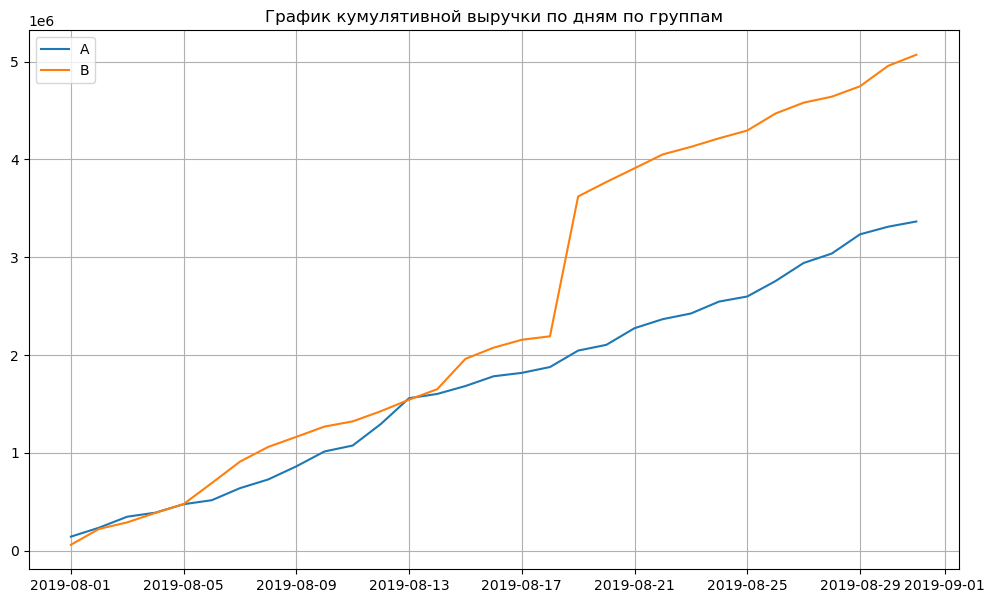

In [14]:
#создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

#cоберём агрегированные кумулятивные по дням данные о заказах в несколько действий. 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

#cоберём агрегированные кумулятивные по дням данные о посетителях сайта в несколько действий.
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия.
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

#график: размер и название
plt.figure(figsize=(12,7))
plt.title('График кумулятивной выручки по дням по группам')
plt.grid(True)

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend(); 

__ВЫВОД:__

В начале теста сегмент А и В шли практически наравне, затем В вырвался вперед и больше не уступал лидерство. У сегмента В видно резкий рост в середине теста. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.  

Построим график кумулятивного среднего чека по группам.

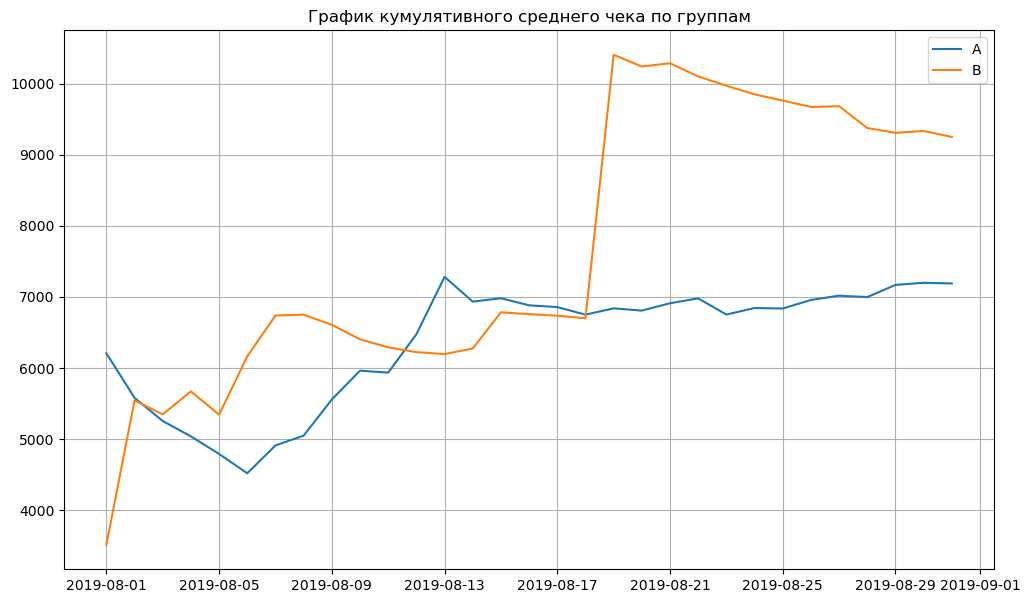

In [15]:
#график: размер и название
plt.figure(figsize=(12,7))
plt.title('График кумулятивного среднего чека по группам')
plt.grid(True)
# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
# Строим график среднего чека группы В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend(); 

__ВЫВОД:__

Кумулятивное значение среднего чека по сегментам колеблется. На это могут повлиять выбросы. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

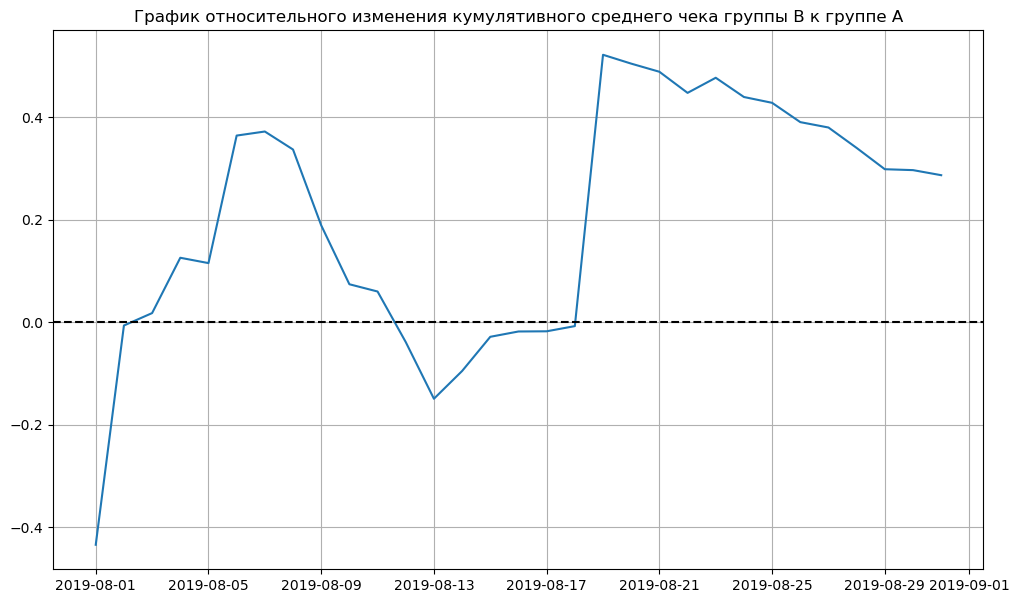

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])

#график: размер и название
plt.figure(figsize=(12,7))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.grid(True)
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
         /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--'); 

__ВЫВОД:__

На графике видно, что результаты теста значительно резко менялись в несколько дат. Скорее всего это из-за совершенных аномальных заказов. 

Построим график кумулятивного среднего количества заказов на посетителя по группам. 

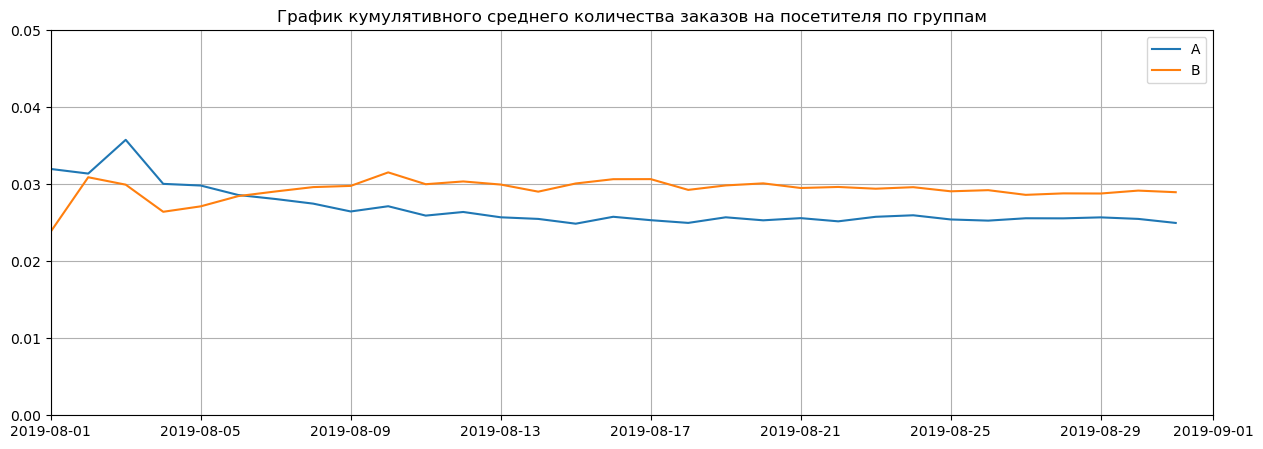

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(15,5))
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.grid(True)

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);

__ВЫВОД:__

В начале теста у сегмента А конверсия была больше сегмента В. Затем сегмент В выровнялся и конверсия стала ненамного больше, чем у сегмента А. 

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

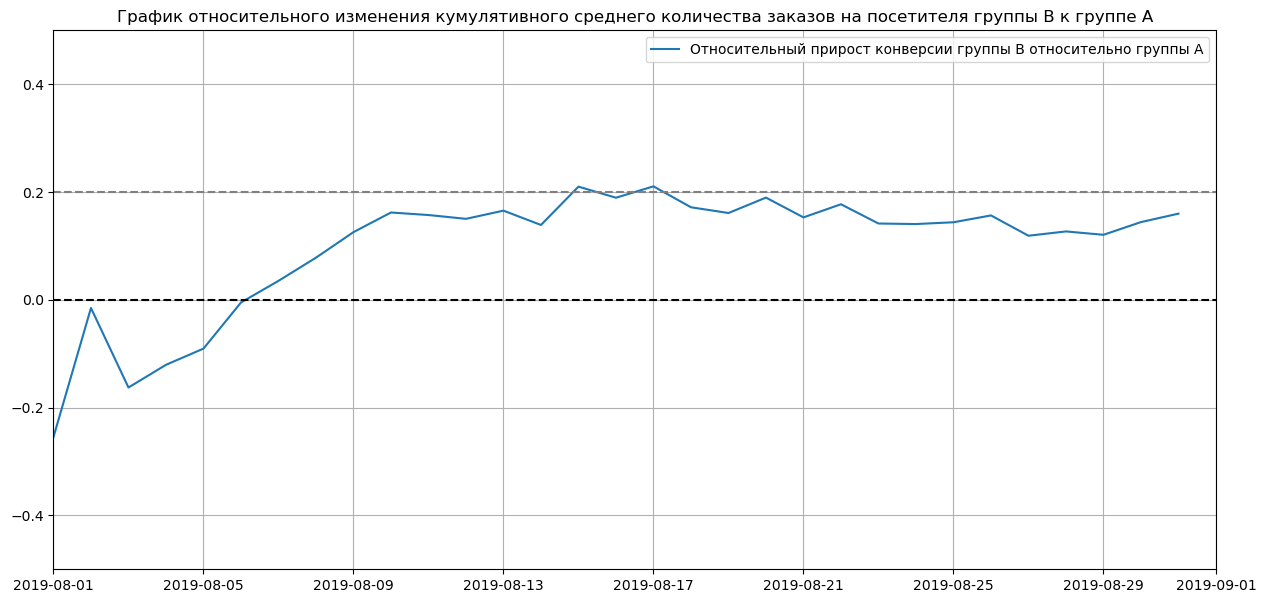

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,7))
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.grid(True)

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5]);

__ВЫВОД:__

В начале теста группа B немного проигрывала группе A, затем вырвалась вперёд. На данный момент группа В выигрывает группу А, примерно на 18%.

### Анализ выбросов и всплесков: крайние значения данных

 В этом разделе изучим данные на аномалии. 
 
 Построим точечный график количества заказов по пользователям.

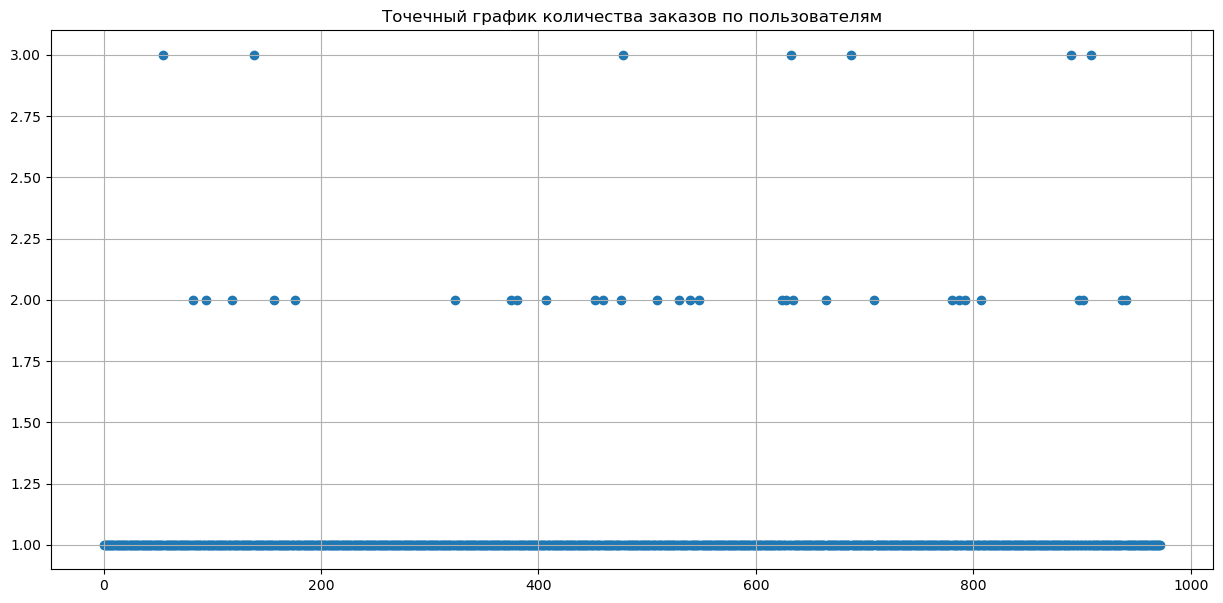

In [19]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
plt.figure(figsize=(15,7))
plt.grid(True)
plt.title('Точечный график количества заказов по пользователям')
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']); 

__ВЫВОД:__

На графике видно, то пользователей сделавших заказ более двух раз мало. Возможно от 3х заказов и выше могут быть аномальными данными. 

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [20]:
#находит перцентили
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

__ВЫВОД:__

Не более 5% пользователей сделали более 2х заказов и не более 1% пользователей сделали более 4х заказов. Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов и отсеять аномальных пользователей по ней. 

Построим точечный график стоимостей заказов. 

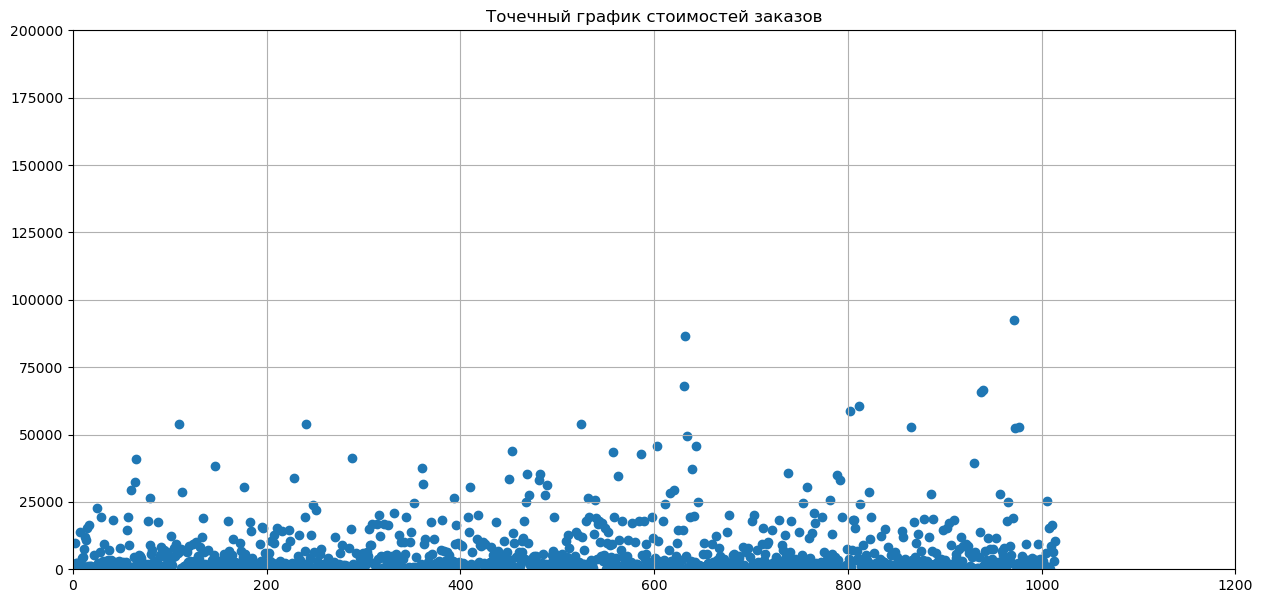

In [21]:
plt.figure(figsize=(15,7))
plt.grid(True)
plt.title('Точечный график стоимостей заказов')
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 200000]); 

__ВЫВОД:__

Заказов стоимостью более 25 000 рублей немного. 

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [22]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

__ВЫВОД:__

Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233.2 рублей. В качестве верхней границы для определения аномальной стоимости заказов выберем 28 000 рублей.

### Анализ A/B-теста

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.

__Сформулируем гипотезы:__
- __Нулевая:__ различий в среднем количестве заказов между группами нет. 
- __Альтернативная:__ различия в среднем количестве заказов между группами есть.

In [23]:
#подготовим данные
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']] 
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

#для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов. 
ordersByUsersA= (
    orders[orders['group'] == 'A'] 
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

#пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули. 
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), 
                               name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), 
                               name='orders')],axis=0) 

print('P-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Относительный прирост среднего группы В к конверсии группы А:', 
      "{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB']\
                        .sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

P-value: 0.01102
Относительный прирост среднего группы В к конверсии группы А: 0.160


__ВЫВОД:__

По «сырым» данным P-value меньше 0.05, поэтому нулевую гипотезу отвергаем. Значит, в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равно 16% 

Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

__Сформулируем гипотезы:__
- __Нулевая:__ различий в среднем чеке между группами между группами нет. 
- __Альтернативная:__ различия в в среднем чеке между группами между группами есть.

In [24]:
print('P-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B:','{0:.3f}'.format(orders[orders['group']=='B']['revenue']\
    .mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.829
Относительный прирост среднего чека группы B: 0.287


__ВЫВОД:__

По «сырым» данным P-value больше 0.05, поэтому нулевую гипотезу не отвергаем. Значит, статистически значимых различий в среднем чеке заказов между группами нет. Однако, относительное различие среднего чека между сегментами 28,7%.


Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами уже по «очищенным» данным — с удалением аномальных пользователей.

__Сформулируем гипотезы:__
- __Нулевая:__ различий в среднем количестве заказов между группами нет. 
- __Альтернативная:__ различия в среднем количестве заказов между группами есть.

In [25]:
#очистим данные от аномалий
#уберем пользователей совершавший более 2х заказов
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['userId'],
    ],
    axis=0,
)

#уберем пользователей совершавший заказы на сумму более 28 000 рублей
usersWithExpensiveOrders = orders[orders['revenue'] >= 28000]['visitorId']

#очищенные данные объединим в таблице abnormalUsers
abnormalUsers = (
     pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
     .drop_duplicates()
     .sort_values()
)

#print(abnormalUsers.head(5))

#подготовим выборки количества заказов по пользователям по группам теста A и В
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('P-value:','{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего группы В к конверсии группы А:','{0:.3f}'\
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value: 0.01299
Относительный прирост среднего группы В к конверсии группы А: 0.162


__ВЫВОД:__

По «очищенным» данным среднего количества заказов практически не отличается от «сырых» данных. P-value меньше 0.05, поэтому нулевую гипотезу отвергаем. Значит, в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равно 16.2%

Посчитаем статистическую значимость различий в среднем чеке заказа между группами между группами уже по «очищенным» данным — с удалением аномальных пользователей.

__Сформулируем гипотезы:__
- __Нулевая:__ различий в среднем чеке заказа между группами нет. 
- __Альтернативная:__ различия в среднем чеке заказа между группами есть.

In [26]:
print( 'P-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительный прирост среднего чека группы B:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.862
Относительный прирост среднего чека группы B: -0.028


__ВЫВОД:__

P-value посчитанный по  «очищенным» данным увеличился по сравнению с посчитанным по "сырым" данным, но и разница между сегментами значительно сократилась. Хотя общие выводы по результатам теста не изменились. 

P-value больше 0.05, поэтому нулевую гипотезу не отвергаем. Значит, статистически значимых различий в среднем чеке заказов между группами нет. Однако, относительное различие среднего чека между сегментами 0,3%.

## Общий вывод.

В проекте была проделана следующая работа: 
- приоритизация выставленных гипотез по увеличению выручки по методу ICE и RICE; 
- проведение A/B-теста: обработка данных, анализ графиков метрик, анализ выбросов и их удаление, анализ A/B-теста.


Приоритизация гипотез вывела следующих лидеров:  
1. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;	
2. Запустить собственную службу доставки, что сократит срок доставки заказов;	
3. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;	
4. Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар.

Анализ A/B-теста показал, что: 
- Есть статистически значимое различие по среднему количеству заказов между группами по «сырым» и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График кумулятивной выручки по дням по группам показал, что в начале теста сегмент А и В шли практически наравне, затем В вырвался примерно на 9% вперёд и больше не уступал лидерство. 
- График кумулятивного среднего чека заказов на посетителя по группам показал, что в начале теста сегмент А имел большую конверсию, затем сегмент В выровнялся и его конверсия стала, больше конверсии сегмента А примерно на 20%.
- График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A показал, что в начале теста группа B немного проигрывала группе A, затем вырвалась вперёд. На данный момент группа В выигрывает группу А, примерно на 10%.

Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Успешнее оказалась группа В. 